# Test Notebook for Recent Changes

This notebook tests two recent changes:
1. **Y-axis scaling fix**: Waterfall charts now properly scale based on min/max of all waterfall points (not just start/end)
2. **Missing lender handling**: Multi-lender decomposition now handles lenders that appear in only one time period

## Test Setup

We'll create two test scenarios:
- **Scenario 1**: Data with large intermediate effects (tests y-axis fix)
- **Scenario 2**: Multi-lender data where one lender appears only in Period 2 (tests missing lender handling)

In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import warnings

# Add src to path
sys.path.insert(0, str(Path.cwd().parent / 'src'))

from symmetric_decomposition_calculator import (
    calculate_decomposition,
    calculate_multi_lender_decomposition
)
from visualization_engine import (
    create_waterfall_grid,
    create_lender_waterfall_grid
)

print("✓ Imports successful")

✓ Imports successful


## Load Base Data

In [2]:
# Load mock data
df_base = pd.read_csv('../data/funnel_data_mock_v2.csv')
df_base['month_begin_date'] = pd.to_datetime(df_base['month_begin_date'])

print(f"Loaded {len(df_base)} rows")
print(f"Lenders: {df_base['lender'].unique()}")
print(f"Date range: {df_base['month_begin_date'].min()} to {df_base['month_begin_date'].max()}")

Loaded 1728 rows
Lenders: ['ACA' 'ALY' 'CAP']
Date range: 2023-01-01 00:00:00 to 2024-12-01 00:00:00


---

## Test 1: Y-Axis Scaling Fix

We'll look for a period comparison that naturally has large intermediate effects.
The y-axis fix ensures that even when start/end are similar, large intermediate effects are properly displayed.

### Strategy:
- Use ACA lender data
- Compare 2023-06-01 vs 2024-06-01 (year-over-year comparison)
- This should have substantial effects across multiple dimensions

In [3]:
# Check year-over-year change for ACA
print("\n=== Test Scenario 1: Y-Axis Scaling ===")
print("Comparing June 2023 vs June 2024 for ACA")

jun23_bks = df_base[(df_base['month_begin_date'] == '2023-06-01') & (df_base['lender'] == 'ACA')]['num_tot_bks'].iloc[0]
jun24_bks = df_base[(df_base['month_begin_date'] == '2024-06-01') & (df_base['lender'] == 'ACA')]['num_tot_bks'].iloc[0]

print(f"\nPeriod 1 (Jun 2023) bookings: {jun23_bks:,.0f}")
print(f"Period 2 (Jun 2024) bookings: {jun24_bks:,.0f}")
print(f"Net change: {jun24_bks - jun23_bks:,.0f} ({(jun24_bks/jun23_bks - 1)*100:.1f}%)")
print("\nExpected: Multiple effects contributing to overall change")


=== Test Scenario 1: Y-Axis Scaling ===
Comparing June 2023 vs June 2024 for ACA

Period 1 (Jun 2023) bookings: 5,092
Period 2 (Jun 2024) bookings: 5,187
Net change: 95 (1.9%)

Expected: Multiple effects contributing to overall change


In [4]:
# Calculate decomposition for Test 1
results_test1 = calculate_decomposition(
    df=df_base,
    date_a='2023-06-01',
    date_b='2024-06-01',
    lender='ACA'
)

print("\n=== Decomposition Summary ===")
summary_display = results_test1.summary[results_test1.summary['effect_type'] != 'interaction_effect'].copy()
print(summary_display.to_string(index=False))

# Calculate metrics to assess if this is a good test case
effects_only = summary_display[summary_display['effect_type'] != 'total_change']
max_effect = effects_only['booking_impact'].abs().max()
total_change = summary_display[summary_display['effect_type'] == 'total_change']['booking_impact'].iloc[0]

print(f"\nLargest individual effect magnitude: {max_effect:,.0f}")
print(f"Total net change: {total_change:,.0f}")
print(f"Ratio: {max_effect / abs(total_change) if total_change != 0 else 0:.2f}x")
print("\n(A high ratio indicates large effects relative to net change - good for testing y-axis scaling)")


=== Decomposition Summary ===
         effect_type  booking_impact
       volume_effect      911.342282
          mix_effect        0.000000
 str_approval_effect       12.324957
cond_approval_effect       47.285843
  str_booking_effect     -688.945317
 cond_booking_effect     -186.435663
        total_change       95.000000

Largest individual effect magnitude: 911
Total net change: 95
Ratio: 9.59x

(A high ratio indicates large effects relative to net change - good for testing y-axis scaling)



✓ Test 1 Chart Generated

VALIDATION CHECKLIST FOR TEST 1:
[ ] Y-axis range accommodates all effects (not cut off)
[ ] All effect bars are clearly visible
[ ] Chart does not look squashed or have excessive whitespace
[ ] All effect labels are readable and properly positioned
[ ] Connector lines properly link all bars


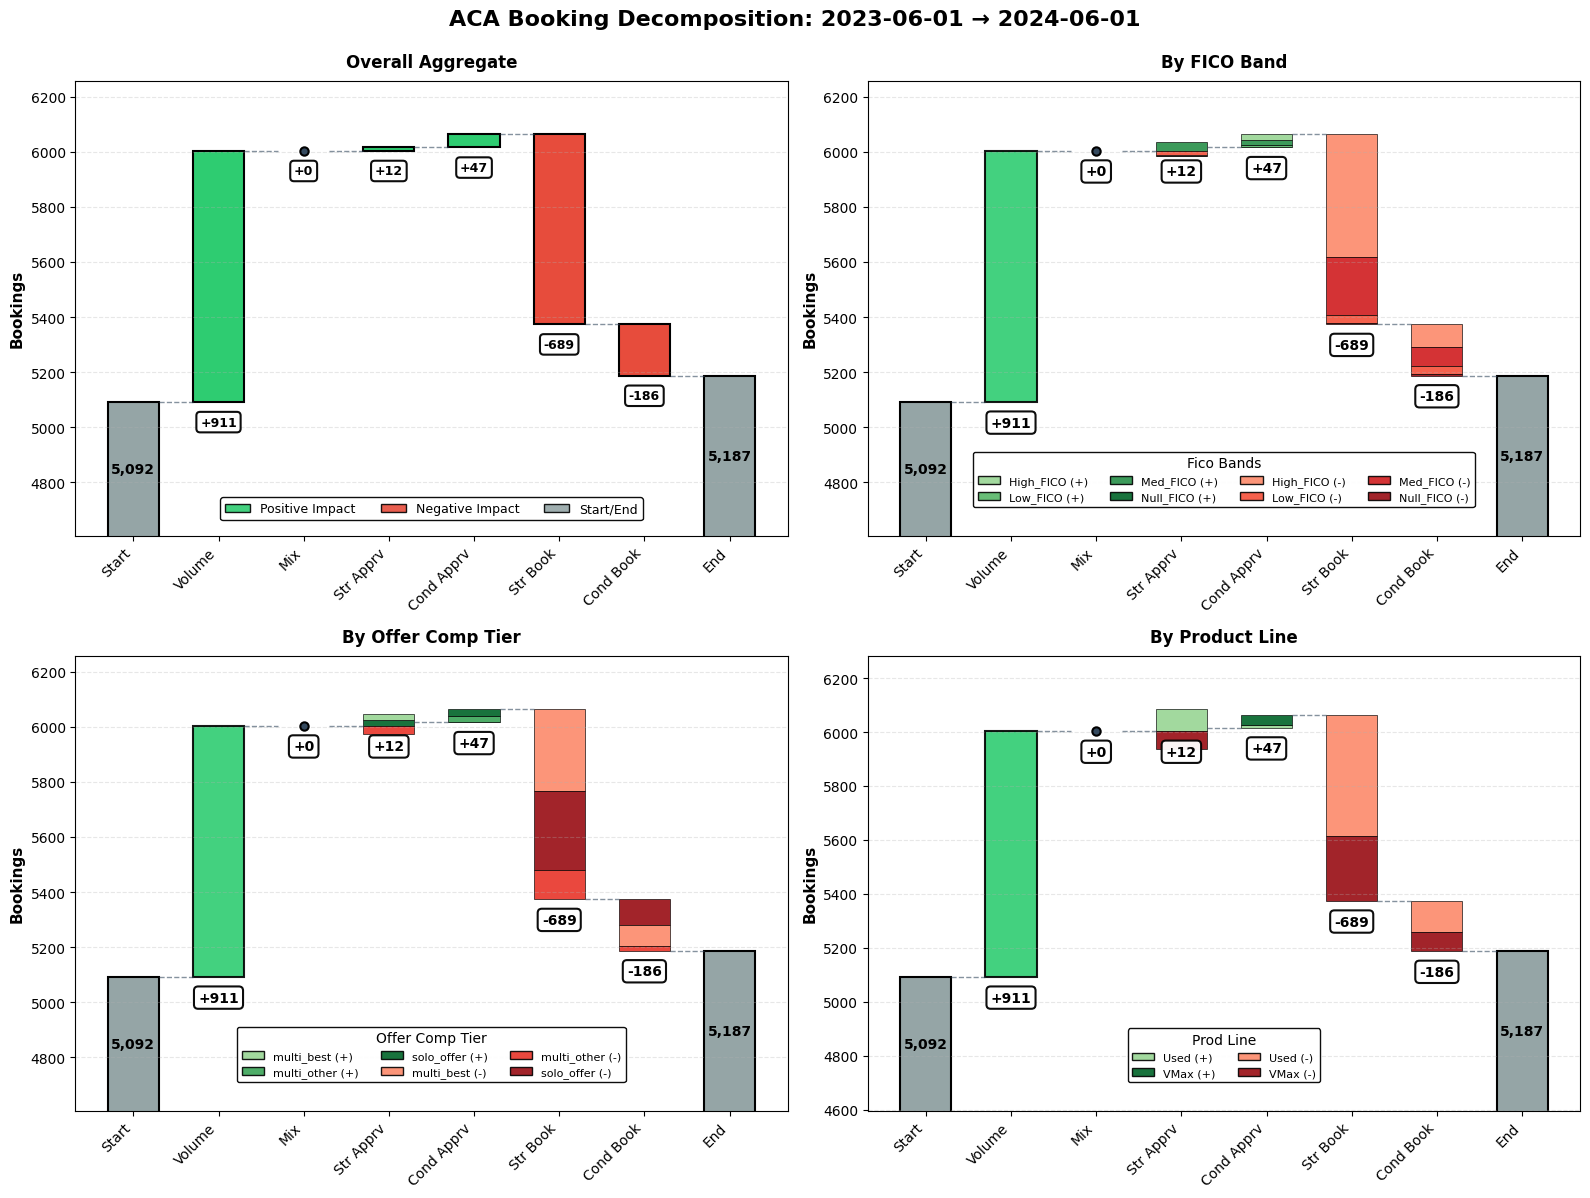

In [5]:
# Create waterfall chart
fig_test1 = create_waterfall_grid(
    summary=results_test1.summary,
    segment_detail=results_test1.segment_detail,
    lender='ACA'
)

print("\n✓ Test 1 Chart Generated")
print("\nVALIDATION CHECKLIST FOR TEST 1:")
print("[ ] Y-axis range accommodates all effects (not cut off)")
print("[ ] All effect bars are clearly visible")
print("[ ] Chart does not look squashed or have excessive whitespace")
print("[ ] All effect labels are readable and properly positioned")
print("[ ] Connector lines properly link all bars")

---

## Test 2: Missing Lender Handling

We'll create a scenario where one lender appears only in Period 2 (simulating a new lender).
The function should warn the user and treat Period 1 as zeros for this lender.

### Strategy:
- Remove ALY lender data from 2024-01-01
- Keep ALY data in 2024-02-01
- Run multi-lender decomposition
- Expect warning about missing lender
- ALY should show full Period 2 bookings as effects

In [6]:
# Create test scenario 2: Missing lender in one period
df_test2 = df_base.copy()

# Remove ALY from 2024-01-01 (Period 1)
df_test2 = df_test2[
    ~((df_test2['lender'] == 'ALY') & (df_test2['month_begin_date'] == '2024-01-01'))
].copy()

print("\n=== Test Scenario 2: Missing Lender ===")
print("\nLenders in Period 1 (2024-01-01):")
period1_lenders = sorted(df_test2[df_test2['month_begin_date'] == '2024-01-01']['lender'].unique())
print(f"  {period1_lenders}")

print("\nLenders in Period 2 (2024-02-01):")
period2_lenders = sorted(df_test2[df_test2['month_begin_date'] == '2024-02-01']['lender'].unique())
print(f"  {period2_lenders}")

print("\n⚠️  Missing in Period 1: ALY (should be treated as zeros)")

# Show ALY's Period 2 bookings
aly_feb_bks = df_test2[(df_test2['month_begin_date'] == '2024-02-01') & (df_test2['lender'] == 'ALY')]['num_tot_bks'].iloc[0]
print(f"\nALY Period 2 bookings: {aly_feb_bks:,.0f}")
print(f"Expected ALY total effect: ~{aly_feb_bks:,.0f} (0 → Period 2 value)")


=== Test Scenario 2: Missing Lender ===

Lenders in Period 1 (2024-01-01):
  ['ACA', 'CAP']

Lenders in Period 2 (2024-02-01):
  ['ACA', 'ALY', 'CAP']

⚠️  Missing in Period 1: ALY (should be treated as zeros)

ALY Period 2 bookings: 2,099
Expected ALY total effect: ~2,099 (0 → Period 2 value)


In [7]:
# Calculate multi-lender decomposition - should warn about missing ALY in Period 1
print("\n=== Running Multi-Lender Decomposition ===")
print("Expected: Warning about ALY missing in Period 1\n")

# Capture warnings
with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    
    results_test2 = calculate_multi_lender_decomposition(
        df=df_test2,
        date_a='2024-01-01',
        date_b='2024-02-01'
    )
    
    # Display warnings
    print()  # Blank line after calculation output
    if w:
        print("\n⚠️  WARNINGS ISSUED:")
        for warning in w:
            print(f"  - {warning.message}")
        print(f"\n✓ Warning correctly issued ({len(w)} warning(s))")
    else:
        print("\n❌ NO WARNINGS ISSUED (Expected a warning!)")


=== Running Multi-Lender Decomposition ===
Expected: Warning about ALY missing in Period 1

Calculating decomposition for ACA...
Calculating decomposition for ALY...
Calculating decomposition for CAP...


⚠️  WARNINGS ISSUED:
  - The following lenders are missing in Period 1 (2024-01-01) and will be treated as zeros: ALY

✓ Warning correctly issued (1 warning(s))


In [8]:
# Check ALY's results
print("\n=== ALY Decomposition Results ===")
aly_summary = results_test2.lender_summaries[
    results_test2.lender_summaries['lender'] == 'ALY'
].copy()

print("\nEffect Breakdown:")
aly_display = aly_summary[aly_summary['effect_type'] != 'interaction_effect'].copy()
print(aly_display.to_string(index=False))

# Verify total change matches expected
total_change = aly_summary[aly_summary['effect_type'] == 'total_change']['booking_impact'].iloc[0]
print(f"\nValidation:")
print(f"  ALY Total Change: {total_change:,.2f}")
print(f"  Expected (Period 2 - 0): {aly_feb_bks:,.2f}")
print(f"  Difference: {abs(total_change - aly_feb_bks):,.2f}")
print(f"  Match: {'✓ YES' if abs(total_change - aly_feb_bks) < 1 else '✗ NO'}")

# Check metadata
aly_metadata = results_test2.lender_details['ALY'].metadata
print(f"\nALY Metadata:")
print(f"  Period 1 bookings: {aly_metadata['period_1_total_bookings']:,.0f}")
print(f"  Period 2 bookings: {aly_metadata['period_2_total_bookings']:,.0f}")
if 'missing_period' in aly_metadata:
    print(f"  Missing period: {aly_metadata['missing_period']}")
    print(f"  ✓ Missing period correctly flagged in metadata")


=== ALY Decomposition Results ===

Effect Breakdown:
lender     effect_type  booking_impact
   ALY lender_addition          2099.0
   ALY    total_change          2099.0

Validation:
  ALY Total Change: 2,099.00
  Expected (Period 2 - 0): 2,099.00
  Difference: 0.00
  Match: ✓ YES

ALY Metadata:
  Period 1 bookings: 0
  Period 2 bookings: 2,099
  Missing period: period_1
  ✓ Missing period correctly flagged in metadata



✓ Test 2 Chart Generated

VALIDATION CHECKLIST FOR TEST 2:
[ ] Warning was issued about ALY missing in Period 1
[ ] ALY total change approximately equals Period 2 bookings
[ ] ALY appears in the lender breakdown chart (right panel)
[ ] ALY's Period 1 bookings = 0 in metadata
[ ] Missing period flagged in ALY's metadata
[ ] Chart renders without errors
[ ] No ValueError raised about missing data


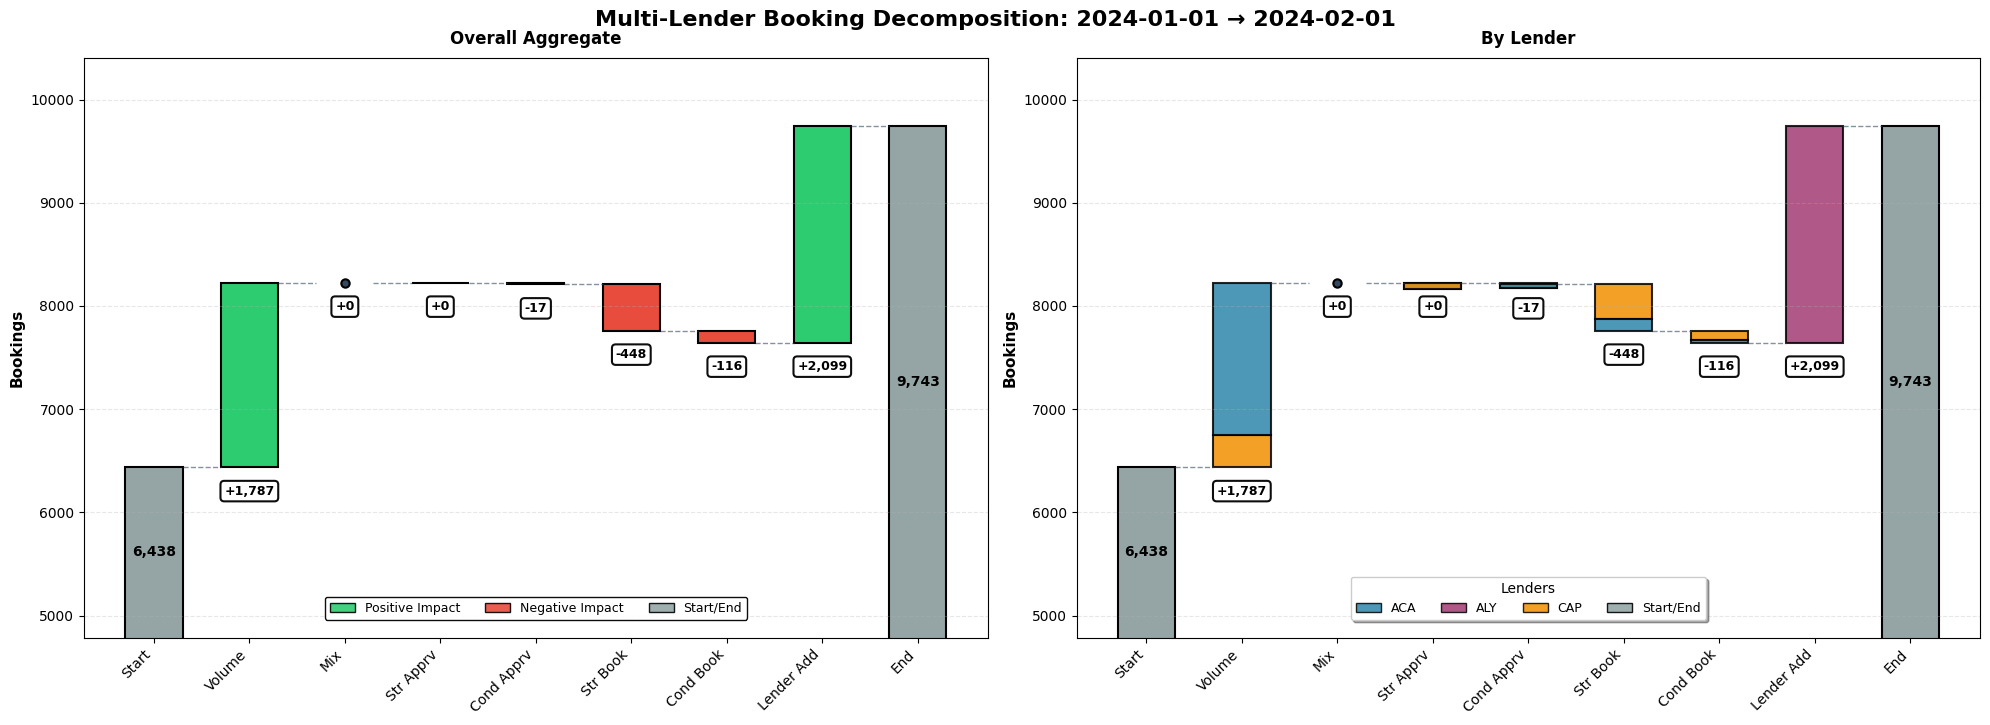

In [9]:
# Create multi-lender waterfall chart
fig_test2 = create_lender_waterfall_grid(
    lender_summaries=results_test2.lender_summaries,
    aggregate_summary=results_test2.aggregate_summary,
    metadata=results_test2.metadata
)

print("\n✓ Test 2 Chart Generated")
print("\nVALIDATION CHECKLIST FOR TEST 2:")
print("[ ] Warning was issued about ALY missing in Period 1")
print("[ ] ALY total change approximately equals Period 2 bookings")
print("[ ] ALY appears in the lender breakdown chart (right panel)")
print("[ ] ALY's Period 1 bookings = 0 in metadata")
print("[ ] Missing period flagged in ALY's metadata")
print("[ ] Chart renders without errors")
print("[ ] No ValueError raised about missing data")

---

## Test 3: Verify Aggregate Includes Missing Lender

Verify that aggregate summary correctly includes all lenders (including ALY with missing period)

In [10]:
print("\n=== Aggregate Summary (All Lenders) ===")
agg_display = results_test2.aggregate_summary[results_test2.aggregate_summary['effect_type'] != 'interaction_effect'].copy()
print(agg_display.to_string(index=False))

print("\n=== Metadata ===")
print(f"Lenders analyzed: {results_test2.metadata['lenders']}")
print(f"Number of lenders: {results_test2.metadata['num_lenders']}")
print(f"\nAggregate Period 1 bookings: {results_test2.metadata['aggregate_period_1_bookings']:,.0f}")
print(f"Aggregate Period 2 bookings: {results_test2.metadata['aggregate_period_2_bookings']:,.0f}")
print(f"Aggregate delta: {results_test2.metadata['aggregate_delta_bookings']:,.0f}")

print("\nVALIDATION:")
print(f"[ ] All three lenders (ACA, ALY, CAP) in metadata: {results_test2.metadata['lenders']}")
print("[ ] Aggregate totals are reasonable")
print("[ ] No errors in calculation")


=== Aggregate Summary (All Lenders) ===
         effect_type  booking_impact
       volume_effect     1787.342856
          mix_effect        0.000000
 str_approval_effect        0.160186
cond_approval_effect      -17.045424
  str_booking_effect     -448.160735
 cond_booking_effect     -116.468295
     lender_addition     2099.000000
        total_change     3305.000000

=== Metadata ===
Lenders analyzed: ['ACA', 'ALY', 'CAP']
Number of lenders: 3

Aggregate Period 1 bookings: 6,438
Aggregate Period 2 bookings: 9,743
Aggregate delta: 3,305

VALIDATION:
[ ] All three lenders (ACA, ALY, CAP) in metadata: ['ACA', 'ALY', 'CAP']
[ ] Aggregate totals are reasonable
[ ] No errors in calculation


---

## Test 4: Additional Test - Lender Missing in Period 2

Test the opposite scenario: lender exists in Period 1 but not Period 2 (lender exit)

In [11]:
# Create test scenario 3: Lender missing in Period 2
df_test3 = df_base.copy()

# Remove CAP from 2024-02-01 (Period 2)
df_test3 = df_test3[
    ~((df_test3['lender'] == 'CAP') & (df_test3['month_begin_date'] == '2024-02-01'))
].copy()

print("\n=== Test Scenario 3: Lender Exit ===")
print("CAP removed from Period 2 (2024-02-01)")

# Show CAP's Period 1 bookings
cap_jan_bks = df_test3[(df_test3['month_begin_date'] == '2024-01-01') & (df_test3['lender'] == 'CAP')]['num_tot_bks'].iloc[0]
print(f"\nCAP Period 1 bookings: {cap_jan_bks:,.0f}")
print(f"Expected CAP total effect: ~{-cap_jan_bks:,.0f} (Period 1 → 0)")


=== Test Scenario 3: Lender Exit ===
CAP removed from Period 2 (2024-02-01)

CAP Period 1 bookings: 2,439
Expected CAP total effect: ~-2,439 (Period 1 → 0)


In [12]:
# Calculate multi-lender decomposition
print("\n=== Running Multi-Lender Decomposition ===")
print("Expected: Warning about CAP missing in Period 2\n")

with warnings.catch_warnings(record=True) as w:
    warnings.simplefilter("always")
    
    results_test3 = calculate_multi_lender_decomposition(
        df=df_test3,
        date_a='2024-01-01',
        date_b='2024-02-01'
    )
    
    print()  # Blank line
    if w:
        print("\n⚠️  WARNINGS ISSUED:")
        for warning in w:
            print(f"  - {warning.message}")
        print(f"\n✓ Warning correctly issued")
    else:
        print("\n❌ NO WARNINGS ISSUED (Expected a warning!)")


=== Running Multi-Lender Decomposition ===
Expected: Warning about CAP missing in Period 2

Calculating decomposition for ACA...
Calculating decomposition for ALY...


Calculating decomposition for CAP...


⚠️  WARNINGS ISSUED:
  - The following lenders are missing in Period 2 (2024-02-01) and will be treated as zeros: CAP

✓ Warning correctly issued


In [13]:
# Check CAP's results
cap_summary = results_test3.lender_summaries[
    results_test3.lender_summaries['lender'] == 'CAP'
].copy()

total_change_cap = cap_summary[cap_summary['effect_type'] == 'total_change']['booking_impact'].iloc[0]
print(f"\nCAP Total Change: {total_change_cap:,.2f}")
print(f"Expected (0 - Period 1): {-cap_jan_bks:,.2f}")
print(f"Match: {'✓ YES' if abs(total_change_cap - (-cap_jan_bks)) < 1 else '✗ NO'}")

cap_metadata = results_test3.lender_details['CAP'].metadata
print(f"\nCAP Metadata:")
print(f"  Period 1 bookings: {cap_metadata['period_1_total_bookings']:,.0f}")
print(f"  Period 2 bookings: {cap_metadata['period_2_total_bookings']:,.0f}")
if 'missing_period' in cap_metadata:
    print(f"  Missing period: {cap_metadata['missing_period']}")
    print(f"  ✓ Missing period correctly flagged")


CAP Total Change: -2,439.00
Expected (0 - Period 1): -2,439.00
Match: ✓ YES

CAP Metadata:
  Period 1 bookings: 2,439
  Period 2 bookings: 0
  Missing period: period_2
  ✓ Missing period correctly flagged


---

## Summary

### Test 1: Y-Axis Scaling Fix
**Purpose**: Verify waterfall charts properly scale based on all waterfall points

**Expected Results**:
- Chart should show all effects clearly
- Y-axis should accommodate all intermediate positions
- No excessive whitespace or squashing

### Test 2: Missing Lender (New Lender)
**Purpose**: Verify handling of lender appearing only in Period 2

**Expected Results**:
- Warning issued about ALY missing in Period 1
- ALY's decomposition: 0 → Period 2 bookings
- Period 1 bookings = 0 in metadata
- Missing period flagged in metadata
- Charts render correctly

### Test 3: Missing Lender (Lender Exit)
**Purpose**: Verify handling of lender appearing only in Period 1

**Expected Results**:
- Warning issued about CAP missing in Period 2
- CAP's decomposition: Period 1 bookings → 0
- Period 2 bookings = 0 in metadata
- Missing period flagged in metadata

### Overall Success Criteria:
✓ No errors during execution
✓ Charts render properly
✓ Appropriate warnings are issued
✓ Reconciliation is exact
✓ Metadata correctly tracks missing periods